In [101]:
from lsst.daf.butler import Butler
from lsst.meas.algorithms import ReferenceObjectLoader
import lsst.geom

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.time import Time
import astropy.units as u

## Set up the "butler" that will fetch the data:

In [2]:
butler = Butler('/repo/embargo', collections='u/csaunder/DM-41130/dev3_vis1')

In [129]:
# The sky is split into "tracts", which are further split into "patches". The "skymap" determines how this is done:
skymap = butler.get('skyMap', skymap='latiss_v1')

### The "visitTable" gives an overview of the conditions for a given visit:

In [3]:
visitTable = butler.get('visitTable')

In [4]:
visitTable

,visit,physical_filter,band,ra,dec,decl,skyRotation,azimuth,altitude,zenithDistance,airmass,expTime,expMidpt,expMidptMJD,obsStart,obsStartMJD
visitId,,,,,,,,,,,,,,,,
2023051100262,2023051100262,SDSSr_65mm~empty,r,239.941279,-24.050861,-24.050861,322.911701,100.652699,33.079204,56.920796,1.826588,30.0,2023-05-12 01:08:56.302993,60076.047874,2023-05-12 01:08:41.302993,60076.047700
2023051100263,2023051100263,SDSSg_65mm~empty,g,239.943099,-24.042851,-24.042851,170.005077,100.427273,33.535722,56.464278,1.804276,30.0,2023-05-12 01:11:06.209005,60076.049377,2023-05-12 01:10:51.209005,60076.049204
2023051100264,2023051100264,SDSSi_65mm~empty,i,239.940919,-24.040927,-24.040927,170.004955,100.024337,34.385246,55.614754,1.765315,30.0,2023-05-12 01:15:04.912000,60076.052140,2023-05-12 01:14:49.912000,60076.051967
2023051100268,2023051100268,SDSSr_65mm~empty,r,239.960079,-24.042010,-24.042010,323.867206,99.573769,35.343223,54.656777,1.724092,30.0,2023-05-12 01:19:39.311494,60076.055316,2023-05-12 01:19:24.311494,60076.055142
2023051100269,2023051100269,SDSSg_65mm~empty,g,239.959845,-24.048026,-24.048026,170.004092,99.360495,35.811664,54.188336,1.704281,30.0,2023-05-12 01:21:49.752999,60076.056826,2023-05-12 01:21:34.752999,60076.056652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023091400082,2023091400082,SDSSr_65mm~empty,r,270.194112,-24.950260,-24.950260,359.998802,263.701292,44.750180,45.249820,1.417337,30.0,2023-09-15 02:35:28.260509,60202.107966,2023-09-15 02:35:13.260509,60202.107792
2023091400083,2023091400083,SDSSr_65mm~empty,r,270.210518,-24.950264,-24.950264,359.998614,263.622517,44.584958,45.415042,1.421490,30.0,2023-09-15 02:36:18.753500,60202.108550,2023-09-15 02:36:03.753500,60202.108377
2023091400084,2023091400084,SDSSr_65mm~empty,r,270.226810,-24.950250,-24.950250,359.998689,263.542128,44.416073,45.583927,1.425701,30.0,2023-09-15 02:37:09.293010,60202.109135,2023-09-15 02:36:54.293010,60202.108962


### The visit summaries have more in-depth info:

In [39]:
visitSummaryRefs = list(butler.registry.queryDatasets('visitSummary', tract=5634, band='r', skymap='latiss_v1'))
visits = np.array([visRef.dataId['visit'] for visRef in visitSummaryRefs])
visitSummaries = [butler.get(visitSummaryRefs[v]) for v in visits.argsort()]
print(f'Tract 5634 has {len(visits)} visits (aka exposures) in r-band')

Tract 5634 has 374 visits (aka exposures) in r-band


In [77]:
# Build a list that we can use to go from the extension index to the visit and detector:
extensionVisits = []
extensionDetectors = []
for visSum in visitSummaries:
    for row in visSum:
        extensionVisits.append(row['visit'])
        extensionDetectors.append(row['id'])

extensionInfo = pd.DataFrame({'visit': extensionVisits,
                              'detector': extensionDetectors})


In [87]:
visits = []
altitudes = []
airmasses = []
mjds = []
ras = []
decs = []
for visSum in visitSummaries:
    visits.append(visSum['visit'][0])
    visInfo = visSum[0].getVisitInfo()
    alt = visInfo.boresightAzAlt.getLatitude().asDegrees()
    altitudes.append(alt)
    airmass = visInfo.boresightAirmass
    airmasses.append(airmass)
    mjd = visInfo.date.get(visInfo.date.MJD)
    mjds.append(mjd)
    raDec = visInfo.boresightRaDec
    ras.append(raDec.getRa().asDegrees())
    decs.append(raDec.getDec().asDegrees())
visitInfo = pd.DataFrame({'visit': visits, 'altitude': altitudes, 'airmass': airmasses,
                          'mjd': mjds, 'ra': ras, 'dec': decs}) 
visitInfo

,visit,altitude,airmass,mjd,ra,dec
0,2023052300621,69.638090,1.066195,60088.215718,270.144118,-25.049109
1,2023052300626,70.431618,1.060891,60088.218336,270.160268,-25.049147
2,2023052300632,71.915991,1.051593,60088.223235,270.176475,-25.049132
3,2023052300645,74.520799,1.037341,60088.231879,270.192944,-25.049119
4,2023052300655,76.330875,1.028910,60088.238001,270.209295,-25.049111
...,...,...,...,...,...,...
369,2023091400082,44.750180,1.417337,60202.107966,270.194112,-24.950260
370,2023091400083,44.584958,1.421490,60202.108550,270.210518,-24.950264
371,2023091400084,44.416073,1.425701,60202.109135,270.226810,-24.950250
372,2023091400085,44.247203,1.429949,60202.109721,270.243077,-24.950268


Text(0, 0.5, 'Altitude')

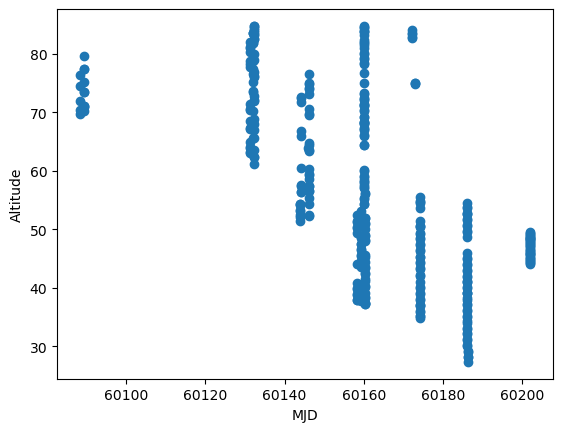

In [36]:
plt.scatter(mjds, altitudes)
plt.xlabel('MJD')
plt.ylabel('Altitude')

Text(0, 0.5, 'Airmass')

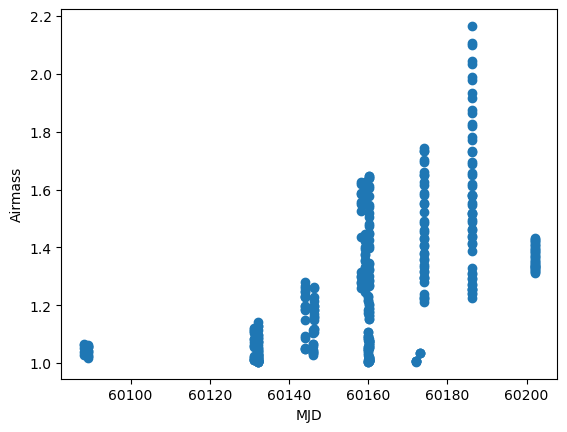

In [37]:
plt.scatter(mjds, airmasses)
plt.xlabel('MJD')
plt.ylabel('Airmass')

### Now let's look at the output of the astrometric fit:

In [8]:
butler.registry.queryDatasetTypes('gbdes*')

[DatasetType('gbdesAstrometricFit_config', {}, Config),
 DatasetType('gbdesAstrometricFit_starCatalog', {band, instrument, skymap, physical_filter, tract}, ArrowNumpyDict),
 DatasetType('gbdesAstrometricFitSkyWcsCatalog', {band, instrument, skymap, physical_filter, tract, visit}, ExposureCatalog),
 DatasetType('gbdesAstrometricFit_fitStars', {band, instrument, skymap, physical_filter, tract}, ArrowNumpyDict),
 DatasetType('gbdesAstrometricFit_metadata', {band, instrument, skymap, physical_filter, tract}, TaskMetadata),
 DatasetType('gbdesAstrometricFit_log', {band, instrument, skymap, physical_filter, tract}, ButlerLogRecords)]

In [58]:
starCatDict = butler.get('gbdesAstrometricFit_starCatalog', skymap='latiss_v1', tract=5634, physical_filter='SDSSr_65mm~empty')
starCatDict['starInvCov'] = starCatDict['starInvCov'].tolist()
starCat = pd.DataFrame(starCatDict)
starCat

,starMatchID,starReserve,starColor,starPMCount,starDetCount,starClipCount,starDOF,starChisq,starX,starY,starPMx,starPMy,starParallax,starInvCov
0,0,False,-888.0,0,2,0,2,4.386844,-89.929544,-24.994483,0.0,0.0,0.0,"[0.5606299583452715, -0.00287514863800916, -0...."
1,1,False,-888.0,0,2,0,2,1.449038,-89.926920,-25.020756,0.0,0.0,0.0,"[1.1770725331311531, -0.00831149871846034, -0...."
2,2,False,-888.0,0,2,0,2,0.046936,-89.926137,-24.935999,0.0,0.0,0.0,"[3.2371116852659445, -0.020032877183524308, -0..."
3,3,False,-888.0,0,2,0,2,4.761145,-89.926204,-25.054878,0.0,0.0,0.0,"[1.8087929221032, -0.010619721657492457, -0.01..."
4,4,False,-888.0,0,2,0,2,1.084361,-89.925627,-25.022477,0.0,0.0,0.0,"[15.356696943370924, -0.0717498846590493, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4623,4623,False,-888.0,0,2,0,2,3.483348,-89.678526,-25.014572,0.0,0.0,0.0,"[0.768501828378629, -0.0052839259527495954, -0..."
4624,4624,False,-888.0,0,2,0,2,1.342775,-89.678551,-24.991095,0.0,0.0,0.0,"[0.8415519987096797, -0.005598865929983926, -0..."
4625,4625,True,-888.0,0,3,0,4,4.572888,-89.678303,-25.055037,0.0,0.0,0.0,"[0.9406979550948308, -0.007149478499763768, -0..."
4626,4626,False,-888.0,0,2,0,2,0.401067,-89.678008,-25.058063,0.0,0.0,0.0,"[1.6673737329229685, -0.009711436875619893, -0..."


In [71]:
starResiduals = pd.DataFrame(butler.get('gbdesAstrometricFit_fitStars', skymap='latiss_v1', tract=5634, physical_filter='SDSSr_65mm~empty'))
starResiduals

,matchID,catalogNumber,objectNumber,clip,reserve,hasPM,color,xresw,yresw,xpix,...,sigpix,xrespix,yrespix,xworld,yworld,chisq,chisqExpected,covTotalW_00,covTotalW_11,covTotalW_01
0,0,351,11934,False,False,False,-888.0,-0.043829,0.006742,270.070456,...,3.344196e-07,360.000000,1.884157e-09,-0.114716,0.005034,0.001125,0.000469,1.784286,0.967478,0.005022
1,0,232,195,False,False,False,-888.0,156.533523,-75.743863,53.088194,...,8.124678e-01,1.624860,-8.126504e-01,-0.114673,0.005013,4.385719,1.999531,6006.533080,6343.915098,-1249.814082
2,1,351,11709,False,False,False,-888.0,-0.019069,0.000122,270.073080,...,2.363627e-07,360.000000,3.871037e-11,-0.112313,-0.021237,0.000428,0.000492,0.849885,0.506651,0.003632
3,1,232,130,False,False,False,-888.0,64.044084,-28.814364,129.341398,...,5.847506e-01,0.665100,-3.097465e-01,-0.112296,-0.021245,1.448610,1.999508,2832.525112,3981.424919,-1212.919252
4,2,351,13162,False,False,False,-888.0,0.001060,-0.002823,270.073863,...,1.426319e-07,360.000000,-7.842971e-10,-0.111680,0.063520,0.000047,0.002587,0.309414,0.184799,0.001165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87070,4625,51,20,False,True,False,-888.0,-69.863689,-30.391452,3956.538712,...,5.242865e-01,-0.734229,-3.082736e-01,0.112922,-0.055527,3.646678,1.999182,1813.817143,3770.791711,-710.840919
87071,4626,351,2239,False,False,False,-888.0,0.001049,-0.001988,270.321992,...,1.950407e-07,360.000000,-5.518999e-10,0.113205,-0.058545,0.000014,0.000121,0.599803,0.332676,0.001947
87072,4626,51,13,False,False,False,-888.0,-34.475793,56.818422,3965.410349,...,9.456592e-01,-0.352820,5.981946e-01,0.113196,-0.058529,0.401053,1.999879,8952.814953,8572.326778,-3114.976318
87073,4627,351,2859,False,False,False,-888.0,0.016453,0.006740,270.322229,...,8.254302e-08,360.000000,1.876387e-09,0.113457,-0.018422,0.003403,0.002103,0.100419,0.063785,0.000147


In [92]:
# To get the visit corresponding to a given source in the starResiduals table:
exampleStarResidual = starResiduals.iloc[0]
correspondingExtension = extensionInfo.iloc[exampleStarResidual['catalogNumber']]
visInfo = visitInfo[visitInfo['visit'] == correspondingExtension['visit']].iloc[0]
print(f"The source at index 0 is from visit {correspondingExtension['visit']} and detector {correspondingExtension['detector']}",
     f"at airmass {visInfo['airmass']:.3f}")
 

The source at index 0 is from visit 2023091400064 and detector 0 at airmass 1.344


### Get the reference catalog data (from Gaia):

In [100]:
gaiaRefs = butler.registry.queryDatasets('gaia_dr3_20230707', tract=5634, skymap='latiss_v1').expanded()
dataIds = [ref.dataId for ref in gaiaRefs]
refCats = [butler.getDeferred(ref) for ref in gaiaRefs]
gaiaLoader = ReferenceObjectLoader(dataIds=dataIds,
                                   refCats=refCats)

In [120]:
ctr = lsst.geom.SpherePoint(-89.8, -25, lsst.geom.degrees)
radius = 0.15 * lsst.geom.degrees
epoch = Time(np.median(mjds), format='mjd')
gaiaCat = gaiaLoader.loadSkyCircle(ctr, radius, 'phot_g_mean', epoch=epoch).refCat.asAstropy()

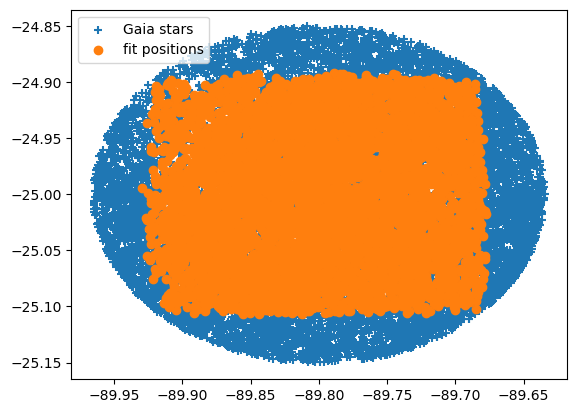

In [122]:
plt.scatter(gaiaCat['coord_ra'].to(u.degree) - 360 * u.degree, gaiaCat['coord_dec'].to(u.degree), label='Gaia stars', marker='+')
plt.scatter(starCat['starX'], starCat['starY'], label='fit positions')
plt.legend()

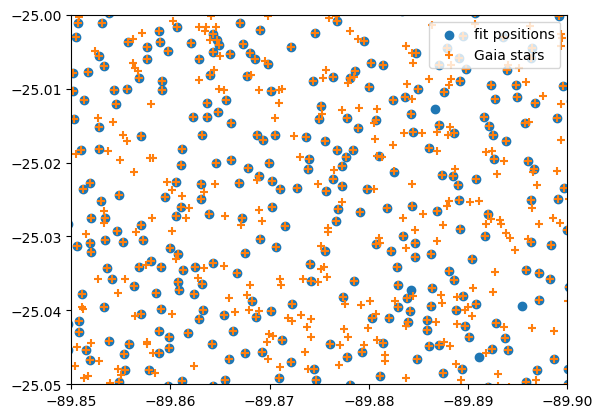

In [128]:
plt.scatter(starCat['starX'], starCat['starY'], label='fit positions')
plt.scatter(gaiaCat['coord_ra'].to(u.degree) - 360 * u.degree, gaiaCat['coord_dec'].to(u.degree), label='Gaia stars', marker='+')
plt.xlim(-89.85, -89.9)
plt.ylim(-25.05, -25.0)
plt.legend()

In [125]:
gaiaCat.colnames

['id',
 'coord_ra',
 'coord_dec',
 'phot_g_mean_flux',
 'phot_bp_mean_flux',
 'phot_rp_mean_flux',
 'phot_g_mean_fluxErr',
 'phot_bp_mean_fluxErr',
 'phot_rp_mean_fluxErr',
 'coord_raErr',
 'coord_decErr',
 'epoch',
 'pm_ra',
 'pm_dec',
 'pm_raErr',
 'pm_decErr',
 'pm_flag',
 'parallax',
 'parallaxErr',
 'parallax_flag',
 'coord_ra_coord_dec_Cov',
 'coord_ra_pm_ra_Cov',
 'coord_ra_pm_dec_Cov',
 'coord_ra_parallax_Cov',
 'coord_dec_pm_ra_Cov',
 'coord_dec_pm_dec_Cov',
 'coord_dec_parallax_Cov',
 'pm_ra_pm_dec_Cov',
 'pm_ra_parallax_Cov',
 'pm_dec_parallax_Cov',
 'astrometric_excess_noise']